# Model Building

## IMPORTS

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import math

## Model Architecture
![Model Architecture](https://raw.githubusercontent.com/Indroneel-roy/HybridCNN-Polyp-Segmentation/main/Model%20Architecture/Hybridecnn.drawio.png)



## CNN ENCODER (ResNet-50)

In [2]:
class ResNetEncoder(nn.Module):
    """ResNet-50 Encoder with multi-scale feature extraction"""
    def __init__(self, pretrained=True):
        super().__init__()

        # Load pretrained ResNet-50
        resnet = models.resnet50(pretrained=pretrained)

        # Initial layers (before Stage 1)
        self.conv1 = resnet.conv1      # 7x7, stride=2 -> 176x176
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool  # 3x3, stride=2 -> 88x88

        # ResNet stages
        self.stage1 = resnet.layer1    # 3 blocks, output: 256 x 88 x 88
        self.stage2 = resnet.layer2    # 4 blocks, output: 512 x 44 x 44
        self.stage3 = resnet.layer3    # 6 blocks, output: 1024 x 22 x 22
        self.stage4 = resnet.layer4    # 3 blocks, output: 2048 x 11 x 11

    def forward(self, x):
        # Initial convolution
        x = self.conv1(x)       # 3x352x352 -> 64x176x176
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)     # 64x176x176 -> 64x88x88

        # Multi-scale features
        s1 = self.stage1(x)     # 256 x 88 x 88
        s2 = self.stage2(s1)    # 512 x 44 x 44
        s3 = self.stage3(s2)    # 1024 x 22 x 22
        s4 = self.stage4(s3)    # 2048 x 11 x 11

        return s1, s2, s3, s4

## TRANSFORMER COMPONENTS

### Multihead Attention

In [3]:
class MultiHeadAttention(nn.Module):
    """Multi-Head Self-Attention mechanism"""
    def __init__(self, d_model=2048, num_heads=8, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        # Query, Key, Value projections
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)

        # Output projection
        self.out_linear = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Linear projections and reshape to (batch, num_heads, seq_len, head_dim)
        Q = self.q_linear(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.k_linear(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.v_linear(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Attention weights
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Apply attention to values
        context = torch.matmul(attn_weights, V)

        # Reshape and project
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.out_linear(context)

        return output

class FeedForward(nn.Module):
    """Position-wise Feed-Forward Network"""
    def __init__(self, d_model=2048, d_ff=8192, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.gelu = nn.GELU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x


In [4]:
class TransformerBlock(nn.Module):
    """Transformer Block with Self-Attention and FFN"""
    def __init__(self, d_model=2048, num_heads=8, d_ff=8192, dropout=0.1):
        super().__init__()

        # Multi-head self-attention
        self.attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)

        # Feed-forward network
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self-attention with residual connection
        attn_output = self.attention(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))

        # Feed-forward with residual connection
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))

        return x


In [5]:
class CrossAttentionBlock(nn.Module):
    """Cross-Attention Block to fuse CNN and Transformer features"""
    def __init__(self, d_model=2048, num_heads=8, dropout=0.1):
        super().__init__()

        self.cross_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, transformer_features, cnn_features):
        """
        transformer_features: Query (from transformer)
        cnn_features: Key and Value (from CNN Stage 4)
        """
        # Cross-attention: Q from transformer, K,V from CNN
        attn_output = self.cross_attention(transformer_features, cnn_features, cnn_features)
        output = self.norm(transformer_features + self.dropout(attn_output))

        return output


## TRANSFORMER BOTTLENECK

In [6]:
class TransformerBottleneck(nn.Module):
    """Transformer Bottleneck for global context modeling"""
    def __init__(self, d_model=2048, num_heads=8, num_blocks=2, dropout=0.1):
        super().__init__()

        self.d_model = d_model

        # Positional encoding (learnable)
        self.pos_encoding = nn.Parameter(torch.randn(1, 121, d_model))  # 121 = 11x11

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_model*4, dropout)
            for _ in range(num_blocks)
        ])

        # Cross-attention with CNN features
        self.cross_attention = CrossAttentionBlock(d_model, num_heads, dropout)

        self.dropout = nn.Dropout(dropout)

    def forward(self, cnn_features):
        """
        cnn_features: (B, 2048, 11, 11) from CNN Stage 4
        """
        B, C, H, W = cnn_features.shape

        # Flatten spatial dimensions: (B, 2048, 11, 11) -> (B, 121, 2048)
        x = cnn_features.flatten(2).transpose(1, 2)  # (B, 121, 2048)

        # Add positional encoding
        x = x + self.pos_encoding
        x = self.dropout(x)

        # First transformer block (self-attention)
        x = self.transformer_blocks[0](x)

        # Cross-attention with CNN features
        cnn_flat = cnn_features.flatten(2).transpose(1, 2)  # (B, 121, 2048)
        x = self.cross_attention(x, cnn_flat)

        # Remaining transformer blocks
        for block in self.transformer_blocks[1:]:
            x = block(x)

        # Reshape back to spatial: (B, 121, 2048) -> (B, 2048, 11, 11)
        x = x.transpose(1, 2).view(B, C, H, W)

        return x


## DECODER BLOCKS

In [7]:
class DecoderBlock(nn.Module):
    """Decoder block with skip connections"""
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()

        # Convolutions after concatenation
        self.conv1 = nn.Conv2d(in_channels + skip_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        # Upsample
        self.upsample = nn.ConvTranspose2d(out_channels, out_channels, 2, stride=2)

    def forward(self, x, skip):
        # Concatenate with skip connection
        x = torch.cat([x, skip], dim=1)

        # Convolutions
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        # Upsample
        x = self.upsample(x)

        return x

In [8]:
class HybridDecoder(nn.Module):
    """Hybrid decoder combining CNN and Transformer features"""
    def __init__(self):
        super().__init__()

        # Decoder blocks
        self.decoder4 = DecoderBlock(2048, 2048, 1024)  # Trans + Skip4 -> 1024x22x22
        self.decoder3 = DecoderBlock(1024, 1024, 512)   # Dec4 + Skip3 -> 512x44x44
        self.decoder2 = DecoderBlock(512, 512, 256)     # Dec3 + Skip2 -> 256x88x88
        self.decoder1 = DecoderBlock(256, 256, 128)     # Dec2 + Skip1 -> 128x176x176

        # Final upsampling
        self.final_upsample = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 2, stride=2),  # 128x352x352
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

    def forward(self, transformer_features, skip1, skip2, skip3, skip4):
        # Decoder Block 4: Transformer + Skip4
        x = self.decoder4(transformer_features, skip4)  # 1024 x 22 x 22

        # Decoder Block 3: Block4 + Skip3
        x = self.decoder3(x, skip3)  # 512 x 44 x 44

        # Decoder Block 2: Block3 + Skip2
        x = self.decoder2(x, skip2)  # 256 x 88 x 88

        # Decoder Block 1: Block2 + Skip1
        x = self.decoder1(x, skip1)  # 128 x 176 x 176

        # Final upsampling
        x = self.final_upsample(x)   # 64 x 352 x 352

        return x

## COMPLETE HYBRID CNN-TRANSFORMER NETWORK

In [9]:
class HybridCNNTransformer(nn.Module):
    """
    Complete Hybrid CNN-Transformer Network for Polyp Segmentation

    Architecture:
        1. CNN Encoder (ResNet-50) - extracts multi-scale features
        2. Transformer Bottleneck - captures global context
        3. Hybrid Decoder - fuses local and global features
        4. Segmentation Head - produces final mask
    """
    def __init__(self, num_classes=1, pretrained=True, num_transformer_blocks=2):
        super().__init__()

        # CNN Encoder
        self.encoder = ResNetEncoder(pretrained=pretrained)

        # Transformer Bottleneck
        self.transformer = TransformerBottleneck(
            d_model=2048,
            num_heads=8,
            num_blocks=num_transformer_blocks,
            dropout=0.1
        )

        # Hybrid Decoder
        self.decoder = HybridDecoder()

        # Segmentation Head
        self.segmentation_head = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        """
        Forward pass

        Args:
            x: Input image (B, 3, 352, 352)

        Returns:
            Output segmentation mask (B, 1, 352, 352)
        """
        # CNN Encoder - extract multi-scale features
        skip1, skip2, skip3, skip4 = self.encoder(x)
        # skip1: 256 x 88 x 88
        # skip2: 512 x 44 x 44
        # skip3: 1024 x 22 x 22
        # skip4: 2048 x 11 x 11

        # Transformer Bottleneck - global context
        transformer_features = self.transformer(skip4)  # 2048 x 11 x 11

        # Hybrid Decoder - fuse features
        decoder_output = self.decoder(transformer_features, skip1, skip2, skip3, skip4)
        # Output: 64 x 352 x 352

        # Segmentation Head
        output = self.segmentation_head(decoder_output)  # 1 x 352 x 352

        return output

## Test the architecture

In [10]:
if __name__ == "__main__":
    # Create model
    model = HybridCNNTransformer(num_classes=1, pretrained=True, num_transformer_blocks=2)

    # Print model summary
    print("=" * 80)
    print("HYBRID CNN-TRANSFORMER NETWORK")
    print("=" * 80)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total Parameters: {total_params / 1e6:.2f}M")
    print(f"Trainable Parameters: {trainable_params / 1e6:.2f}M")

    # Test forward pass
    print("\n" + "=" * 80)
    print("TESTING FORWARD PASS")
    print("=" * 80)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Random input
    batch_size = 2
    x = torch.randn(batch_size, 3, 352, 352).to(device)

    print(f"Input shape: {x.shape}")

    # Forward pass
    with torch.no_grad():
        output = model(x)

    print(f"Output shape: {output.shape}")
    print(f"Expected shape: ({batch_size}, 1, 352, 352)")

    # Apply sigmoid for visualization
    output_sigmoid = torch.sigmoid(output)
    print(f"\nOutput range after sigmoid: [{output_sigmoid.min():.4f}, {output_sigmoid.max():.4f}]")

    print("\n" + "=" * 80)
    print("MODEL READY FOR TRAINING!")
    print("=" * 80)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s] 


HYBRID CNN-TRANSFORMER NETWORK
Total Parameters: 209.69M
Trainable Parameters: 209.69M

TESTING FORWARD PASS
Input shape: torch.Size([2, 3, 352, 352])
Output shape: torch.Size([2, 1, 352, 352])
Expected shape: (2, 1, 352, 352)

Output range after sigmoid: [0.2003, 0.9015]

MODEL READY FOR TRAINING!


# Training


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
from tqdm import tqdm

## Loss Function

## Dice loss

In [12]:
class DiceLoss(nn.Module):
    """Dice Loss for segmentation"""
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
        
    def forward(self, predictions, targets):
        # Apply sigmoid if needed
        predictions = torch.sigmoid(predictions)
        
        # Flatten
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        # Dice coefficient
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        # Dice loss
        return 1 - dice

In [13]:
class CombinedLoss(nn.Module):
    """Combined Dice + BCE Loss"""
    def __init__(self, dice_weight=0.5, bce_weight=0.5):
        super().__init__()
        self.dice_loss = DiceLoss()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        
    def forward(self, predictions, targets):
        dice = self.dice_loss(predictions, targets)
        bce = self.bce_loss(predictions, targets)
        return self.dice_weight * dice + self.bce_weight * bce


## DATASET

In [14]:
class PolypDataset(Dataset):
    """Dataset for polyp segmentation"""
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        # Get all image files
        self.images = sorted(os.listdir(image_dir))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load mask
        mask_path = os.path.join(self.mask_dir, img_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Apply transformations
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        
        # Normalize mask to [0, 1]
        mask = mask.float() / 255.0
        mask = mask.unsqueeze(0)  # Add channel dimension
        
        return image, mask


## DATA AUGMENTATION

In [15]:
def get_train_transforms(image_size=352):
    """Training augmentations"""
    return A.Compose([
        A.Resize(image_size, image_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])


def get_val_transforms(image_size=352):
    """Validation augmentations"""
    return A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

## Matrics

In [16]:
def dice_coefficient(predictions, targets, threshold=0.5):
    """Calculate Dice coefficient"""
    predictions = (torch.sigmoid(predictions) > threshold).float()
    targets = targets.float()
    
    intersection = (predictions * targets).sum()
    dice = (2. * intersection) / (predictions.sum() + targets.sum() + 1e-8)
    
    return dice.item()


def iou_score(predictions, targets, threshold=0.5):
    """Calculate IoU (Jaccard Index)"""
    predictions = (torch.sigmoid(predictions) > threshold).float()
    targets = targets.float()
    
    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum() - intersection
    iou = intersection / (union + 1e-8)
    
    return iou.item()


## TRAINING LOOP

In [20]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    
    total_loss = 0
    total_dice = 0
    total_iou = 0
    
    pbar = tqdm(dataloader, desc='Training')
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        dice = dice_coefficient(outputs, masks)
        iou = iou_score(outputs, masks)
        
        total_loss += loss.item()
        total_dice += dice
        total_iou += iou
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice:.4f}',
            'iou': f'{iou:.4f}'
        })
    
    avg_loss = total_loss / len(dataloader)
    avg_dice = total_dice / len(dataloader)
    avg_iou = total_iou / len(dataloader)
    
    return avg_loss, avg_dice, avg_iou


def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    
    total_loss = 0
    total_dice = 0
    total_iou = 0
    
    pbar = tqdm(dataloader, desc='Validation')
    with torch.no_grad():
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Calculate metrics
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
            
            total_loss += loss.item()
            total_dice += dice
            total_iou += iou
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice:.4f}',
                'iou': f'{iou:.4f}'
            })
    
    avg_loss = total_loss / len(dataloader)
    avg_dice = total_dice / len(dataloader)
    avg_iou = total_iou / len(dataloader)
    
    return avg_loss, avg_dice, avg_iou

## MAIN TRAINING FUNCTION
<!--  -->

In [18]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=50,
    save_dir='checkpoints'
):
    """Complete training loop"""
    
    os.makedirs(save_dir, exist_ok=True)
    best_dice = 0.0
    
    print("=" * 80)
    print("STARTING TRAINING")
    print("=" * 80)
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 80)
        
        # Train
        train_loss, train_dice, train_iou = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # Validate
        val_loss, val_dice, val_iou = validate_epoch(
            model, val_loader, criterion, device
        )
        
        # Learning rate scheduling
        scheduler.step()
        
        # Print epoch summary
        print(f"\nEpoch {epoch + 1} Summary:")
        print(f"Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Save best model
        if val_dice > best_dice:
            best_dice = val_dice
            checkpoint_path = os.path.join(save_dir, 'best_model.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_dice': best_dice,
            }, checkpoint_path)
            print(f"✓ Saved best model (Dice: {best_dice:.4f})")
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
            }, checkpoint_path)
            print(f"✓ Saved checkpoint at epoch {epoch+1}")
    
    print("\n" + "=" * 80)
    print(f"TRAINING COMPLETE! Best Dice Score: {best_dice:.4f}")
    print("=" * 80)


In [19]:
def plot_training_history(history, save_dir='/kaggle/working/'):
    """Plot training history"""
    import matplotlib.pyplot as plt
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Loss
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12, weight='bold')
    axes[0].set_ylabel('Loss', fontsize=12, weight='bold')
    axes[0].set_title('Training and Validation Loss', fontsize=14, weight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Dice Coefficient
    axes[1].plot(epochs, history['train_dice'], 'b-', label='Train Dice', linewidth=2)
    axes[1].plot(epochs, history['val_dice'], 'r-', label='Val Dice', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12, weight='bold')
    axes[1].set_ylabel('Dice Coefficient', fontsize=12, weight='bold')
    axes[1].set_title('Training and Validation Dice', fontsize=14, weight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: IoU
    axes[2].plot(epochs, history['train_iou'], 'b-', label='Train IoU', linewidth=2)
    axes[2].plot(epochs, history['val_iou'], 'r-', label='Val IoU', linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=12, weight='bold')
    axes[2].set_ylabel('IoU', fontsize=12, weight='bold')
    axes[2].set_title('Training and Validation IoU', fontsize=14, weight='bold')
    axes[2].legend(fontsize=10)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    plot_path = os.path.join(save_dir, 'training_history.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f"\n✓ Training plots saved to {plot_path}")
    plt.show()
    plt.close()

In [21]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Configuration
IMAGE_SIZE = 352
BATCH_SIZE = 8
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Original data paths
KVASIR_IMAGE_DIR = '/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images'
KVASIR_MASK_DIR = '/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/masks'

# Split dataset (80% train, 20% val)
all_images = sorted(os.listdir(KVASIR_IMAGE_DIR))
train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)

# Create output directories
os.makedirs('data/train/images', exist_ok=True)
os.makedirs('data/train/masks', exist_ok=True)
os.makedirs('data/val/images', exist_ok=True)
os.makedirs('data/val/masks', exist_ok=True)

# Copy train files
for img in train_images:
    shutil.copy(os.path.join(KVASIR_IMAGE_DIR, img), f'data/train/images/{img}')
    shutil.copy(os.path.join(KVASIR_MASK_DIR, img), f'data/train/masks/{img}')

# Copy val files
for img in val_images:
    shutil.copy(os.path.join(KVASIR_IMAGE_DIR, img), f'data/val/images/{img}')
    shutil.copy(os.path.join(KVASIR_MASK_DIR, img), f'data/val/masks/{img}')

# Updated data paths
TRAIN_IMAGE_DIR = 'data/train/images'
TRAIN_MASK_DIR = 'data/train/masks'
VAL_IMAGE_DIR = 'data/val/images'
VAL_MASK_DIR = 'data/val/masks'

print("=" * 80)
print("HYBRID CNN-TRANSFORMER TRAINING")
print("=" * 80)
print(f"Device: {DEVICE}")
print(f"Image Size: {IMAGE_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")

# Create datasets
train_dataset = PolypDataset(
    TRAIN_IMAGE_DIR,
    TRAIN_MASK_DIR,
    transform=get_train_transforms(IMAGE_SIZE)
)

val_dataset = PolypDataset(
    VAL_IMAGE_DIR,
    VAL_MASK_DIR,
    transform=get_val_transforms(IMAGE_SIZE)
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"\nDataset sizes:")
print(f"Train: {len(train_dataset)} images")
print(f"Val: {len(val_dataset)} images")

# Create model
model = HybridCNNTransformer(
    num_classes=1,
    pretrained=True,
    num_transformer_blocks=2
)
model = model.to(DEVICE)

# Loss function
criterion = CombinedLoss(dice_weight=0.5, bce_weight=0.5)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)



HYBRID CNN-TRANSFORMER TRAINING
Device: cuda
Image Size: 352
Batch Size: 8
Learning Rate: 0.0001
Epochs: 100


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



Dataset sizes:
Train: 800 images
Val: 200 images


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=50
):
    """Complete training loop with plotting"""
    
    best_dice = 0.0
    SAVE_PATH = '/kaggle/working/best_model.pth'
    
    # Lists to store metrics for plotting
    history = {
        'train_loss': [],
        'train_dice': [],
        'train_iou': [],
        'val_loss': [],
        'val_dice': [],
        'val_iou': []
    }
    
    print("=" * 80)
    print("STARTING TRAINING")
    print("=" * 80)
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 80)
        
        # Train
        train_loss, train_dice, train_iou = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # Validate
        val_loss, val_dice, val_iou = validate_epoch(
            model, val_loader, criterion, device
        )
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        
        # Learning rate scheduling
        scheduler.step()
        
        # Print epoch summary
        print(f"\nEpoch {epoch + 1} Summary:")
        print(f"Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Save ONLY best model to /kaggle/working/
        if val_dice > best_dice:
            best_dice = val_dice
            
            # Remove old model first to save space
            if os.path.exists(SAVE_PATH):
                os.remove(SAVE_PATH)
            
            # Save new best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_dice': best_dice,
            }, SAVE_PATH)
            print(f"✓ Saved best model (Dice: {best_dice:.4f}) to {SAVE_PATH}")
        
        # Plot metrics every 10 epochs
        if (epoch + 1) % 10 == 0 or (epoch + 1) == num_epochs:
            plot_training_history(history)
    
    print("\n" + "=" * 80)
    print(f"TRAINING COMPLETE! Best Dice Score: {best_dice:.4f}")
    print("=" * 80)
    
    # Final plot
    plot_training_history(history)
    
    return history


In [ ]:
# Train model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    num_epochs=60)

# After training, download model manually
# Go to Kaggle Output tab → you will see best_model.pth and training_history.png
print("✓ Check Kaggle Output tab to download best_model.pth")

# Inference 

Loading model from /kaggle/input/hybrid-cnn/pytorch/default/1/best_model.pth...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✓ Model loaded successfully.

Running Inference on 5 random validation samples...



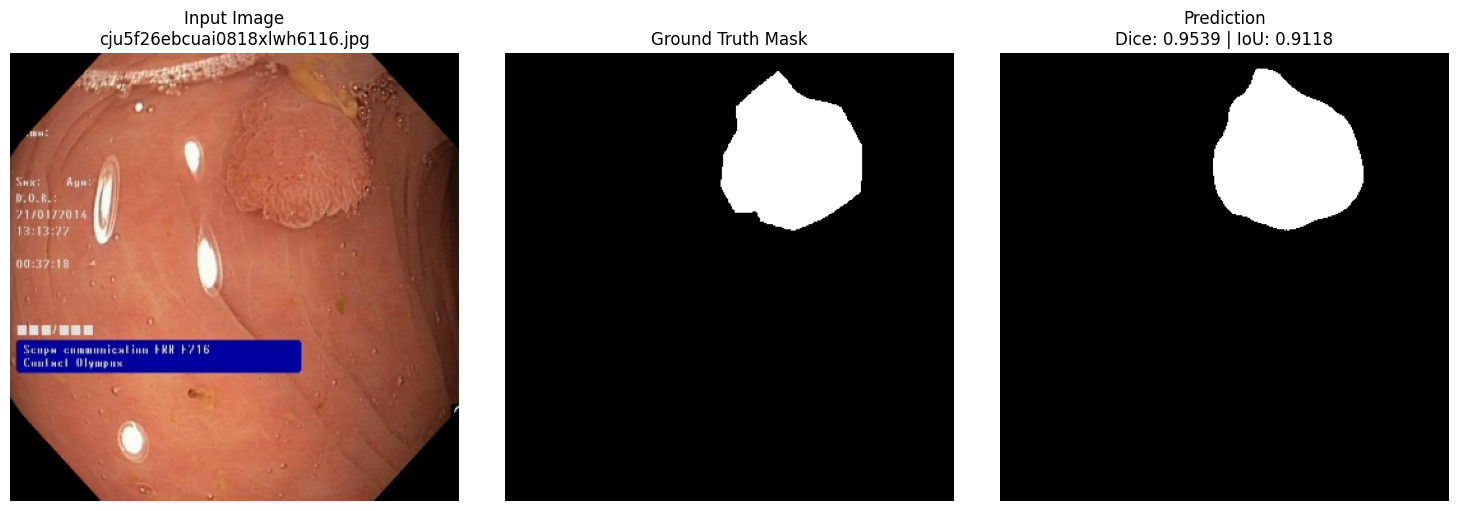

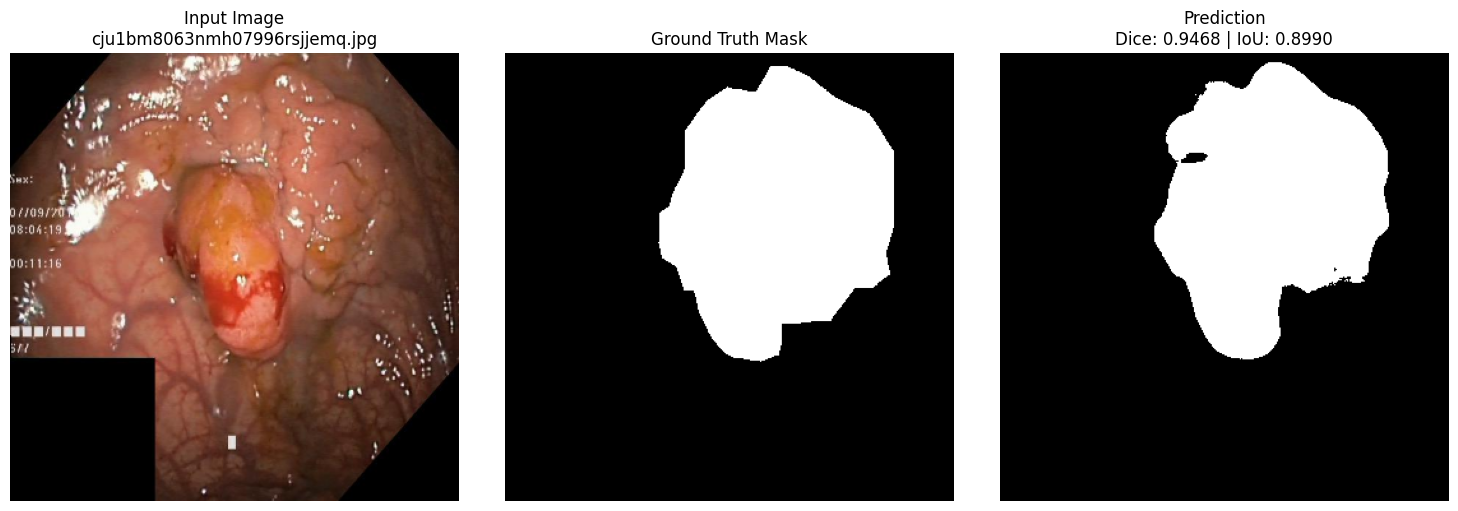

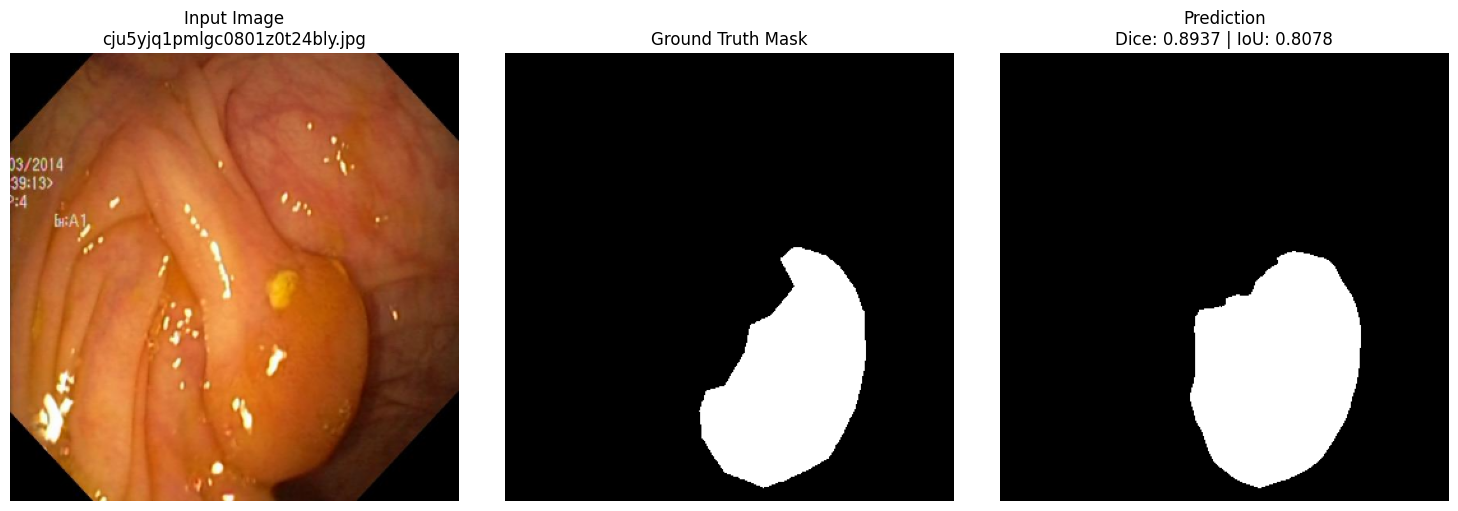

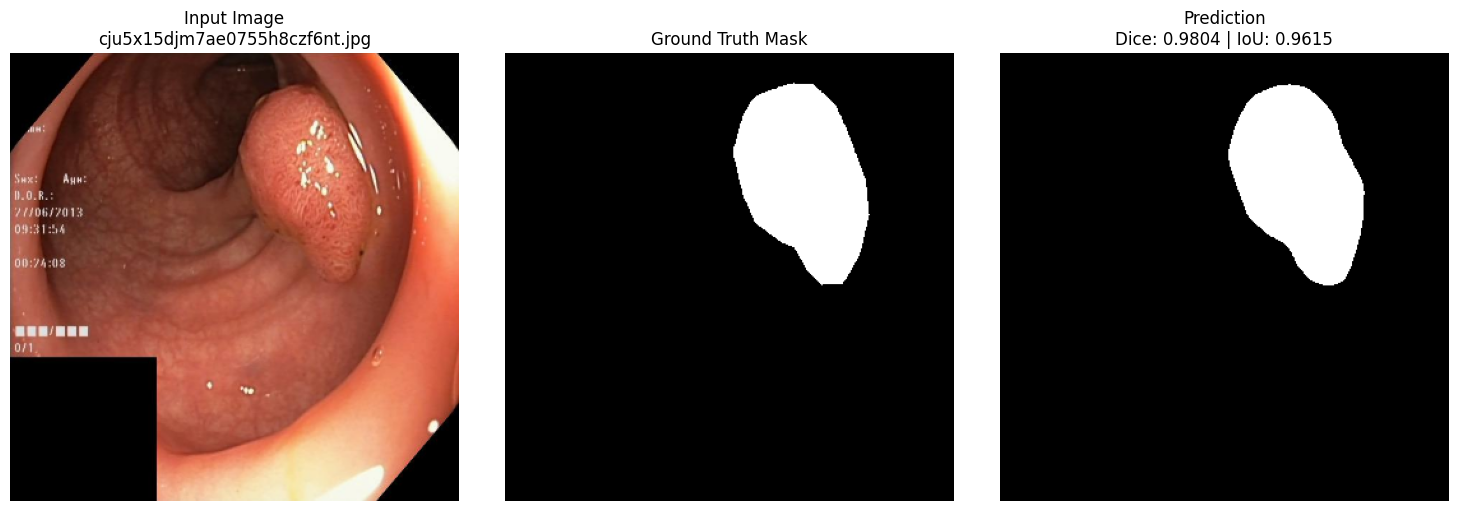

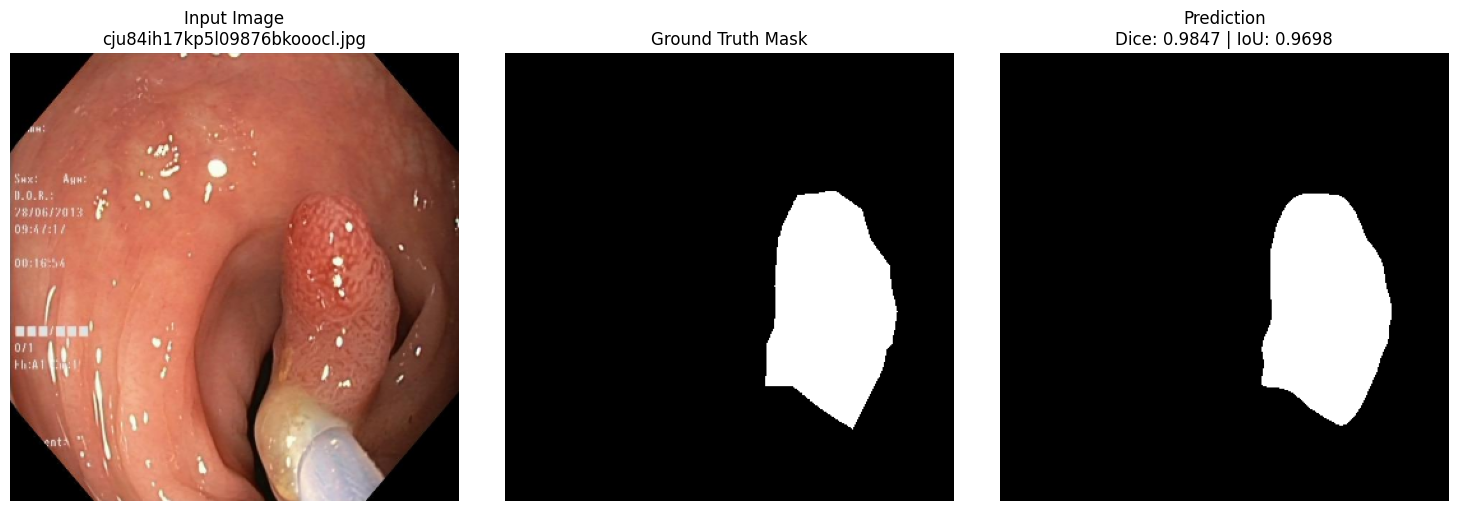

In [23]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from albumentations.pytorch import ToTensorV2
import albumentations as A

# ==========================================
# 1. CONFIGURATION
# ==========================================
class InferenceConfig:
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    MODEL_PATH = '/kaggle/input/hybrid-cnn/pytorch/default/1/best_model.pth'  # Path where your best model is saved
    IMG_SIZE = 352
    THRESHOLD = 0.5  # Threshold to convert probability to binary mask

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================

def get_inference_transforms():
    """Matches the validation transforms from training"""
    return A.Compose([
        A.Resize(InferenceConfig.IMG_SIZE, InferenceConfig.IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

def calculate_metrics_single(pred_mask, gt_mask):
    """
    Calculate Dice and IoU for a single prediction.
    Args:
        pred_mask (np.array): Binary prediction mask (0 or 1)
        gt_mask (np.array): Binary ground truth mask (0 or 1)
    """
    # Flatten
    pred = pred_mask.flatten()
    gt = gt_mask.flatten()
    
    intersection = np.sum(pred * gt)
    
    # Dice Score
    dice = (2. * intersection) / (np.sum(pred) + np.sum(gt) + 1e-8)
    
    # IoU Score
    union = np.sum(pred) + np.sum(gt) - intersection
    iou = intersection / (union + 1e-8)
    
    return dice, iou

def load_trained_model(model_class, checkpoint_path, device):
    """Loads the model architecture and weights"""
    print(f"Loading model from {checkpoint_path}...")
    
    # Initialize the model architecture (Must match training config)
    model = model_class(num_classes=1, pretrained=False, num_transformer_blocks=2)
    
    # Load weights
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
        
    model.to(device)
    model.eval()
    print("✓ Model loaded successfully.")
    return model

def predict_and_compare(model, image_path, mask_path, transform, device):
    """
    Runs inference and compares with Ground Truth.
    """
    # 1. Load and Preprocess Image
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # 2. Load Ground Truth Mask
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = gt_mask.astype(np.float32) / 255.0
    gt_mask = cv2.resize(gt_mask, (InferenceConfig.IMG_SIZE, InferenceConfig.IMG_SIZE))
    # Binarize GT
    gt_mask = (gt_mask > 0.5).astype(np.float32)

    # 3. Apply Transforms
    augmented = transform(image=original_img)
    img_tensor = augmented['image'].unsqueeze(0).to(device) # Add batch dim

    # 4. Model Inference
    with torch.no_grad():
        logits = model(img_tensor)
        pred_prob = torch.sigmoid(logits)
        pred_mask = (pred_prob > InferenceConfig.THRESHOLD).float()
    
    # Convert to numpy for metrics/plotting
    pred_mask_np = pred_mask.squeeze().cpu().numpy()
    
    # 5. Calculate Performance
    dice, iou = calculate_metrics_single(pred_mask_np, gt_mask)
    
    return original_img, gt_mask, pred_mask_np, dice, iou

# ==========================================
# 3. VISUALIZATION
# ==========================================

def visualize_comparison(image, gt, pred, dice, iou, img_name):
    plt.figure(figsize=(15, 5))
    
    # Input Image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.resize(image, (InferenceConfig.IMG_SIZE, InferenceConfig.IMG_SIZE)))
    plt.title(f"Input Image\n{img_name}")
    plt.axis('off')
    
    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(gt, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')
    
    # Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap='gray')
    plt.title(f"Prediction\nDice: {dice:.4f} | IoU: {iou:.4f}")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# ==========================================
# 4. MAIN EXECUTION
# ==========================================

if __name__ == "__main__":
    # Ensure model is defined (Assumes HybridCNNTransformer class exists in context)
    if 'HybridCNNTransformer' not in globals():
        print("Error: Model class not found. Please run the model definition cells first.")
    else:
        # Load Model
        model = load_trained_model(
            HybridCNNTransformer, 
            InferenceConfig.MODEL_PATH, 
            InferenceConfig.DEVICE
        )
        
        # Setup Validation Directory (Using the paths from your training code)
        val_img_dir = '/kaggle/working/data/val/images'
        val_mask_dir = '/kaggle/working/data/val/masks'
        
        val_files = sorted(os.listdir(val_img_dir))
        
        # Select 5 Random Samples to Test
        num_samples = 5
        test_samples = random.sample(val_files, min(len(val_files), num_samples))
        
        print(f"\nRunning Inference on {len(test_samples)} random validation samples...\n")
        
        transforms = get_inference_transforms()
        
        for img_name in test_samples:
            img_path = os.path.join(val_img_dir, img_name)
            mask_path = os.path.join(val_mask_dir, img_name)
            
            # Run Inference
            image, gt, pred, dice, iou = predict_and_compare(
                model, 
                img_path, 
                mask_path, 
                transforms, 
                InferenceConfig.DEVICE
            )
            
            # Show Results
            visualize_comparison(image, gt, pred, dice, iou, img_name)